In [0]:
import os
# To work with Amazon S3 storage, set the following variables using your AWS Access Key and Secret Key
# Set the Region to where your files are stored in S3.
access_key = 'xxxxxxxxxxxxxx'
secret_key = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxx'
# Set the environment variables so boto3 can pick them up later
os.environ['AWS_ACCESS_KEY_ID'] = access_key
os.environ['AWS_SECRET_ACCESS_KEY'] = secret_key
encoded_secret_key = secret_key.replace("/", "%2F")
aws_region = "us-east-2"

# Update the Spark options to work with our AWS Credentials
sc._jsc.hadoopConfiguration().set("fs.s3a.access.key", access_key)
sc._jsc.hadoopConfiguration().set("fs.s3a.secret.key", secret_key)
sc._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "s3." + aws_region + ".amazonaws.com")

clean_sdf = spark.read.parquet('s3a://hvfhv-project-mc/raw/cleaned_fhvhv_tripdata_2023-01.parquet')

In [0]:
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, Binarizer, Bucketizer, MinMaxScaler
from pyspark.ml.stat import Correlation, ChiSquareTest, Summarizer
from pyspark.ml import Pipeline

# Import the logistic regression model
from pyspark.ml.classification import LogisticRegression, LogisticRegressionModel

# Import the evaluation module
from pyspark.ml.evaluation import *

# Import the model tuning module
from pyspark.ml.tuning import *

# Import other modeling modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the Spark logging level to only show errors
sc.setLogLevel("ERROR")

In [0]:
# FEATURE ENGINEERING SECTION

# Rename trip_time to trip_time_secs
# Convert trip_time_secs from long to double

trip_time_sec = clean_sdf.withColumnRenamed('trip_time', 'trip_time_secs')
trip_time_sec_sdf = trip_time_sec.withColumn('trip_time_secs', col('trip_time_secs').cast('double'))

# Subtract request_datetime from pickup_datetime to get total wait time from after request was submitted, in seconds. Convert to double.

total_wait_secs_sdf = trip_time_sec_sdf.withColumn('total_wait_secs', col('pickup_datetime').cast('double') - col('request_datetime').cast('double'))

# Extract the hour from pickup_datetime to know what time of day the ride occurred. Convert to double.

pickup_hour_sdf = total_wait_secs_sdf.withColumn('pickup_hour', hour(col('pickup_datetime')).cast('double'))

# Bucketize pickup_hour by 6 hour periods: <=6 = Early Morning, <12 = Morning, ==12 = Noon, <=18 = Afternoon, <=24 = Night

bucketized_pickup_hour_sdf = pickup_hour_sdf.withColumn('pickup_time_of_day', when(col('pickup_hour') <= 6, 'Early Morning').when(col('pickup_hour') < 12, "Morning").when(col('pickup_hour') == 12, 'Noon').when(col('pickup_hour') <= 18, "Afternoon").when(col('pickup_hour') <= 24, "Night"))

# Extract the day of the week from pickup_datetime to know what day the ride occurred. Convert to double.

day_of_week_num_sdf = bucketized_pickup_hour_sdf.withColumn('day_of_week_num', dayofweek(col('pickup_datetime')).cast('double'))

# Create a column called day_name to specify the day name associated with day_of_week_num

bucketized_day_name_sdf = day_of_week_num_sdf.withColumn('day_name', when(col('day_of_week_num') == 1, 'Monday').when(col('day_of_week_num') == 2, 'Tuesday').when(col('day_of_week_num') == 3, 'Wednesday').when(col('day_of_week_num') == 4, 'Thursday').when(col('day_of_week_num') == 5, 'Friday').when(col('day_of_week_num') == 6, 'Saturday').when(col('day_of_week_num') == 7, 'Sunday'))

# Binarize day_of_week to 0 or 1, where 0.0 = Weekday, 1.0 = Weekend

binarizer_day = Binarizer(threshold=5.0, inputCol='day_of_week_num', outputCol='weekday_or_weekend')
weekday_or_weekend_sdf = binarizer_day.transform(bucketized_day_name_sdf)

# Create a column called total_fare that includes all of the ride costs

total_fare_sdf = weekday_or_weekend_sdf.withColumn('total_fare', col('base_passenger_fare') + col('tolls') + col('bcf') + col('sales_tax') + col('congestion_surcharge') + col('airport_fee'))

# Drop all rows where total_fare is equal to 0.0 to avoid a divide by zero error
# Create a column called tip_percent that is tips divided by total_fare to get the tip percent

non_zero_fare = total_fare_sdf.where(col('total_fare') > 0.0)
tip_percent_sdf = non_zero_fare.withColumn('tip_percent', col('tips') / col('total_fare'))

tip_percent_sdf.show()

+-------------------+-------------------+-------------------+-------------------+----------+--------------+-------------------+-----+----+---------+--------------------+-----------+-----+---------------+-----------+------------------+---------------+--------+------------------+------------------+-------------------+
|   request_datetime|  on_scene_datetime|    pickup_datetime|   dropoff_datetime|trip_miles|trip_time_secs|base_passenger_fare|tolls| bcf|sales_tax|congestion_surcharge|airport_fee| tips|total_wait_secs|pickup_hour|pickup_time_of_day|day_of_week_num|day_name|weekday_or_weekend|        total_fare|        tip_percent|
+-------------------+-------------------+-------------------+-------------------+----------+--------------+-------------------+-----+----+---------+--------------------+-----------+-----+---------------+-----------+------------------+---------------+--------+------------------+------------------+-------------------+
|2023-01-01 00:18:06|2023-01-01 00:19:24|2023-

In [0]:
# PIPELINE CREATION SECTION

# Create a label. =1 if >= 0.01, =0 otherwise
binarizer_tip = Binarizer(threshold=0.01, inputCol='tip_percent', outputCol='label')
tip_label = binarizer_tip.transform(tip_percent_sdf)

# Create an indexer for the string based columns
indexer = StringIndexer(inputCols=["pickup_time_of_day", "day_name"], outputCols=["pickup_time_of_day_index", "day_name_index"])

# Create an encoder for the three indexes and the age integer column
encoder = OneHotEncoder(inputCols=['pickup_time_of_day_index', 'day_name_index'], outputCols=['pickup_time_of_day_vector', 'day_name_vector'], dropLast=False)

# Create an assembler for the individual feature vectors and the float/double columns
assembler = VectorAssembler(inputCols=['trip_miles', 'trip_time_secs', 'total_wait_secs', 'pickup_time_of_day_vector', 'day_name_vector', 'weekday_or_weekend', 'total_fare'], outputCol='features')

# Scale the features columns so the min = 0.0 and max = 1.0
min_max_scaler = MinMaxScaler(inputCol='features', outputCol='scaled_features')

# # Create the pipeline
# hvfhv_pipe = Pipeline(stages=[indexer, encoder, assembler, min_max_scaler])

# # Call .fit to transform the data
# transformed_sdf = hvfhv_pipe.fit(tip_label).transform(tip_label)

# # Review the transformed features
# transformed_sdf.select('trip_miles', 'trip_time_secs', 'total_wait_secs', 'pickup_time_of_day', 'day_name', 'weekday_or_weekend', 'total_fare', 'tip_percent', 'label', 'features', 'scaled_features').show(truncate=False)

In [0]:
# Create a LogisticRegression Estimator
lr = LogisticRegression()

hvfhv_pipe = Pipeline(stages=[indexer, encoder, assembler, min_max_scaler, lr])

# Split the data into 70% training and 30% test sets
trainingData, testData = tip_label.randomSplit([0.7, 0.3], seed=42)

# Create a grid to hold hyperparameters
grid = ParamGridBuilder()
grid = grid.addGrid(lr.regParam, [0.0, 1.0])
grid = grid.addGrid(lr.elasticNetParam, [0, 1])

# Build the parameter grid
grid = grid.build()

# How many models to be tested
print('Number of models to be tested: ', len(grid))

# Create a BinaryClassificationEvaluator to evaluate how well the model works
evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
# Create the CrossValidator using the hyperparameter grid
cv = CrossValidator(estimator=hvfhv_pipe,
                    estimatorParamMaps=grid,
                    evaluator=evaluator,
                    numFolds=3)

# Train the models
cv  = cv.fit(trainingData)

Number of models to be tested:  4


In [0]:
# Test the predictions
predictions = cv.transform(testData)

# Calculate AUC
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc}")

# Create the confusion matrix
predictions.groupby('label').pivot('prediction').count().fillna(0).show()
cm = predictions.groupby('label').pivot('prediction').count().fillna(0).collect()

def calculate_recall_precision(cm):
    tn = cm[0][1]                # True Negative
    fp = cm[0][2]                # False Positive
    fn = cm[1][1]                # False Negative
    tp = cm[1][2]                # True Positive
    precision = tp / ( tp + fp )            
    recall = tp / ( tp + fn )
    accuracy = ( tp + tn ) / ( tp + tn + fp + fn )
    f1_score = 2 * ( ( precision * recall ) / ( precision + recall ) )
    return accuracy, precision, recall, f1_score

print("Accuracy, Precision, Recall, F1 Score")
print( calculate_recall_precision(cm) )

AUC: 0.5967993319002812
+-----+-------+----+
|label|    0.0| 1.0|
+-----+-------+----+
|  0.0|3266899|9535|
|  1.0| 790598|5243|
+-----+-------+----+

Accuracy, Precision, Recall, F1 Score
(0.8035169530544966, 0.3547841385843822, 0.006587999361681542, 0.012935793510884891)


LogisticRegression_af08595af35e__aggregationDepth 2
LogisticRegression_af08595af35e__elasticNetParam 1.0
LogisticRegression_af08595af35e__family auto
LogisticRegression_af08595af35e__featuresCol features
LogisticRegression_af08595af35e__fitIntercept True
LogisticRegression_af08595af35e__labelCol label
LogisticRegression_af08595af35e__maxBlockSizeInMB 0.0
LogisticRegression_af08595af35e__maxIter 100
LogisticRegression_af08595af35e__predictionCol prediction
LogisticRegression_af08595af35e__probabilityCol probability
LogisticRegression_af08595af35e__rawPredictionCol rawPrediction
LogisticRegression_af08595af35e__regParam 0.0
LogisticRegression_af08595af35e__standardization True
LogisticRegression_af08595af35e__threshold 0.5
LogisticRegression_af08595af35e__tol 1e-06


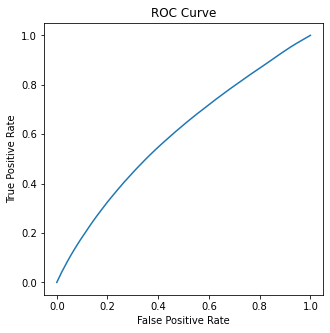

In [0]:
# Look at the parameters for the best model that was evaluated from the grid
parammap = cv.bestModel.stages[4].extractParamMap()

for p, v in parammap.items():
    print(p, v)

# Grab the model from Stage 3 of the pipeline
mymodel = cv.bestModel.stages[4]

import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
plt.plot(mymodel.summary.roc.select('FPR').collect(),
         mymodel.summary.roc.select('TPR').collect())
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
plt.savefig("roc1.png")
plt.show()

In [0]:
# Extract the coefficients on each of the variables
coeff = mymodel.coefficients.toArray().tolist()

# Loop through the features to extract the original column names. Store in the var_index dictionary
var_index = dict()
for variable_type in ['numeric', 'binary']:
    for variable in predictions.schema["features"].metadata["ml_attr"]["attrs"][variable_type]:
         print(f"Found variable: {variable}" )
         idx = variable['idx']
         name = variable['name']
         var_index[idx] = name      # Add the name to the dictionary

# Loop through all of the variables found and print out the associated coefficients
for i in range(len(var_index)):
    print(f"Coefficient {i} {var_index[i]}  {coeff[i]}")

Found variable: {'idx': 0, 'name': 'trip_miles'}
Found variable: {'idx': 1, 'name': 'trip_time_secs'}
Found variable: {'idx': 2, 'name': 'total_wait_secs'}
Found variable: {'idx': 16, 'name': 'total_fare'}
Found variable: {'idx': 3, 'name': 'pickup_time_of_day_vector_Afternoon'}
Found variable: {'idx': 4, 'name': 'pickup_time_of_day_vector_Night'}
Found variable: {'idx': 5, 'name': 'pickup_time_of_day_vector_Morning'}
Found variable: {'idx': 6, 'name': 'pickup_time_of_day_vector_Early Morning'}
Found variable: {'idx': 7, 'name': 'pickup_time_of_day_vector_Noon'}
Found variable: {'idx': 8, 'name': 'day_name_vector_Monday'}
Found variable: {'idx': 9, 'name': 'day_name_vector_Sunday'}
Found variable: {'idx': 10, 'name': 'day_name_vector_Saturday'}
Found variable: {'idx': 11, 'name': 'day_name_vector_Wednesday'}
Found variable: {'idx': 12, 'name': 'day_name_vector_Tuesday'}
Found variable: {'idx': 13, 'name': 'day_name_vector_Friday'}
Found variable: {'idx': 14, 'name': 'day_name_vector_Th

In [0]:
# MODEL EVALUATION SECTION

# Save the confusion matrix
cm = test_results.groupby('label').pivot('prediction').count().fillna(0).collect()

def calculate_recall_precision(cm):
    tn = cm[0][1] # True Negative
    fp = cm[0][2] # False Positive
    fn = cm[1][1] # False Negative
    tp = cm[1][2] # True Positive
    precision = tp / ( tp + fp )
    recall = tp / ( tp + fn )
    accuracy = ( tp + tn ) / ( tp + tn + fp + fn )
    f1_score = 2 * ( ( precision * recall ) / ( precision + recall ) )
    return accuracy, precision, recall, f1_score

print('Accuracy, Precision, Recall, F1 Score')
print(calculate_recall_precision(cm))

In [0]:
# MODEL EVALUATION SECTION
# RUN CROSS-VALIDATOR ON TRAINING DATA

# Create a BinaryClassificationEvaluator to evaluate how well the model works
evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")

# Create the parameter grid (empty for now)
grid = ParamGridBuilder().build()

# Create the CrossValidator
cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator, numFolds=3 )

# Use the CrossValidator to Fit the training data
cv = cv.fit(trainingData)

# Show the average performance over the three folds
print('cv.avgMetrics:', cv.avgMetrics)

In [0]:
# MODEL EVALUATION SECTION

# Evaluate the test data using the cross-validator model
# Reminder: We used Area Under the Curve
print('evaluator.evaluate(cv.transform(testData)):', evaluator.evaluate(cv.transform(testData)))

In [0]:
# MODEL EVALUATION SECTION 
# PARAMETER GRID SEARCH

# Create a grid to hold hyperparameters
grid = ParamGridBuilder()
grid = grid.addGrid(lr.regParam, [0.0, 1.0] )
grid = grid.addGrid(lr.elasticNetParam, [0, 1])

# Build the grid
grid = grid.build()
print('Number of models to be tested:', len(grid))

# Create the CrossValidator using the new hyperparameter grid
cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator)

# Call cv.fit() to create models with all of the combinations of parameters in the grid
all_models = cv.fit(trainingData)
print("Average Metrics for Each model:", all_models.avgMetrics)

In [0]:
# MODEL EVALUATION SECTION
# CHARACTERISTICS OF BEST MODEL

# Gather the metrics and parameters of the model with the best average metrics
hyperparams = all_models.getEstimatorParamMaps()[np.argmax(all_models.avgMetrics)]

# Print out the list of hyperparameters for the best model
for i in range(len(hyperparams.items())):
    print([x for x in hyperparams.items()][i])

#(Param(parent='LogisticRegression_2effdf339a6c', name='regParam', doc='regularization parameter (>= 0).'), 0.4)
#(Param(parent='LogisticRegression_2effdf339a6c', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'), 0.0)

# Choose the best model
bestModel = all_models.bestModel
print("Area under ROC curve:", bestModel.summary.areaUnderROC)

# Area under ROC curve: 1.0

In [0]:
# MODEL EVALUATION SECTION
# TEST BEST MODEL ON TEST DATA

# Use the model 'bestModel' to predict the test set
test_results = bestModel.transform(testData)

# Show the results
# test_results.select('trip_miles', 'trip_time_secs', 'total_wait_secs', 'pickup_time_of_day', 'day_name', 'weekday_or_weekend', 'total_fare', 'tip_percent','probability','prediction', 'label').show(truncate=False)

# Evaluate the predictions. Area Under ROC curve
print('evaluator.evaluate(test_results):', evaluator.evaluate(test_results))